# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [353]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

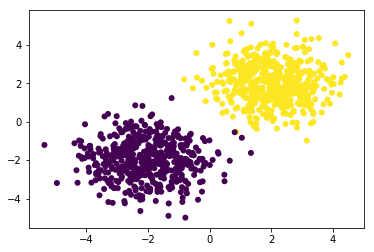

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 10))
net.add(ReLU())
net.add(Linear(10, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 2
LogSoftMax

Linear 2 -> 10
ReLU
Linear 10 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 1000

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

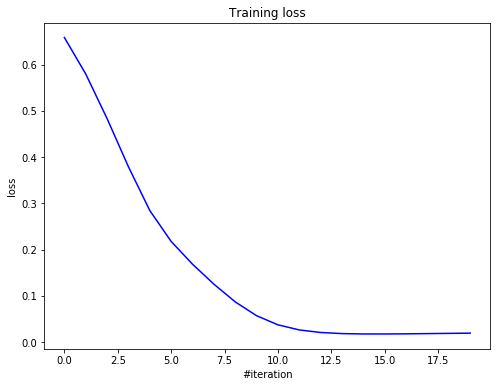

Current loss: 0.019291


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [520]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [521]:
# Your code goes here. ################################################
Y = [];
for i in range(len(y)):
    tmp = np.zeros(10);
    tmp[int(y[i])] = 1;
    Y.append(tmp);
Y = np.round(Y)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [60]:
# Your code goes here. ################################################
import time
def nettest(lr, mom, n_epoch,batch_size):
    loss_history = []
    # Optimizer params
    optimizer_config = {'learning_rate' : lr, 'momentum': mom}
    optimizer_state = {}
    start_time = time.time()
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)
        print("Time passed: %f seconds" % (time.time() - start_time))
    return loss_history;

#### `ReLU` activation function WITHOUT  `BatchNormalization`

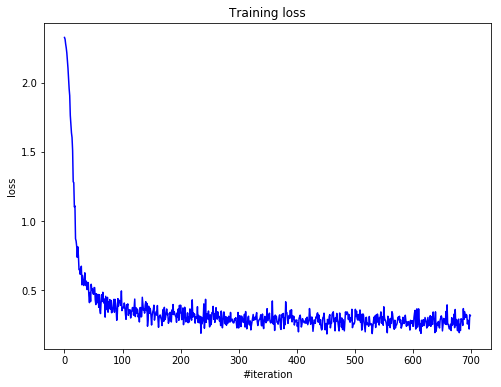

Current loss: 0.315663
Time passed: 224.402845 seconds


In [148]:
net = Sequential()
net.add(Linear(784, 10))
net.add(ReLU())
net.add(Linear(10, 10))
net.add(LogSoftMax())
print(net)
ReLU2_hist = nettest(1e-1, 0.9,5,500);

#### `ReLU` activation function WITH  `BatchNormalization`

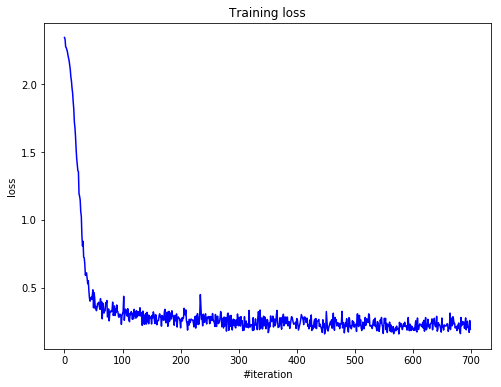

Current loss: 0.190560
Time passed: 224.320653 seconds


In [71]:
net = Sequential()
net.add(Linear(784, 10))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(10))
net.add(ReLU())
net.add(Linear(10, 10))
net.add(LogSoftMax())
print(net)
Batch_ReLU_hist = nettest(1e-1, 0.9,5,500);

#### `ELU` activation function without  `BatchNormalization`

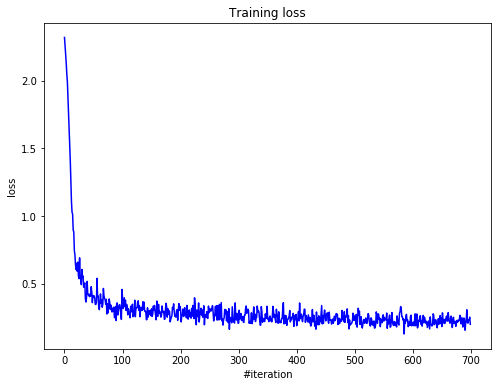

Current loss: 0.198564
Time passed: 237.629034 seconds


In [74]:
net = Sequential()
net.add(Linear(784, 10))
net.add(ELU())
net.add(Linear(10, 10))
net.add(LogSoftMax())
print(net)
ELU_hist = nettest(1e-1, 0.9,5,500);

#### `ELU` activation function WITH  `BatchNormalization`

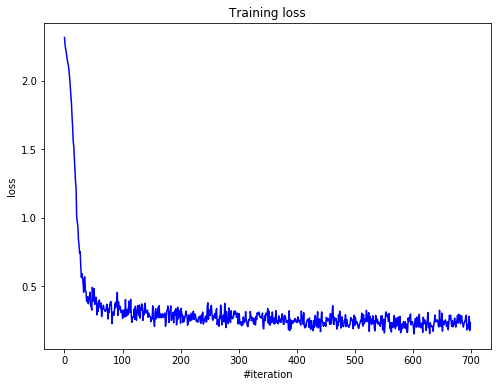

Current loss: 0.235307
Time passed: 236.382500 seconds


In [75]:
net = Sequential()
net.add(Linear(784, 10))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(10))
net.add(ELU())
net.add(Linear(10, 10))
net.add(LogSoftMax())
print(net)
Batch_ELU_hist = nettest(1e-1, 0.9,5,500);

#### `LeakyReLU` activation function without  `BatchNormalization`

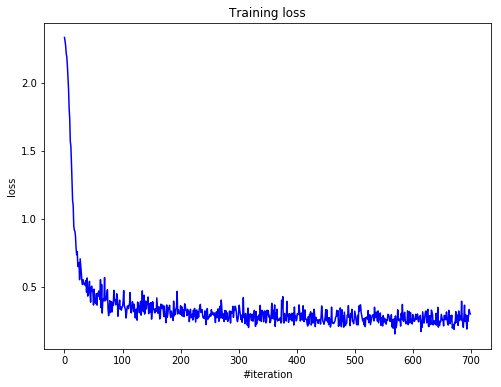

Current loss: 0.301062
Time passed: 219.291758 seconds


In [77]:
net = Sequential()
net.add(Linear(784, 10))
net.add(LeakyReLU())
net.add(Linear(10, 10))
net.add(LogSoftMax())
print(net)
LeakyReLU_hist = nettest(1e-1, 0.9,5,500);

#### `LeakyReLU` activation function WITH  `BatchNormalization`

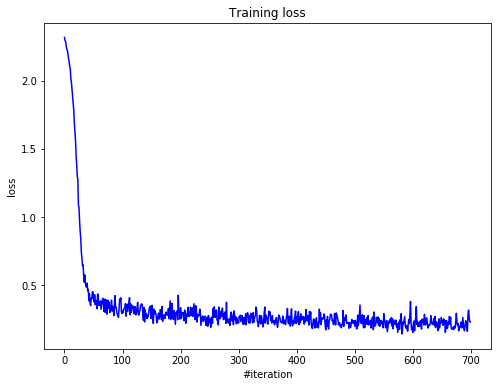

Current loss: 0.233139
Time passed: 225.222701 seconds


In [78]:
net = Sequential()
net.add(Linear(784, 10))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(10))
net.add(LeakyReLU())
net.add(Linear(10, 10))
net.add(LogSoftMax())
print(net)
Batch_LeakyReLU_hist = nettest(1e-1, 0.9,5,500);

#### `SoftPlus` activation function without  `BatchNormalization`

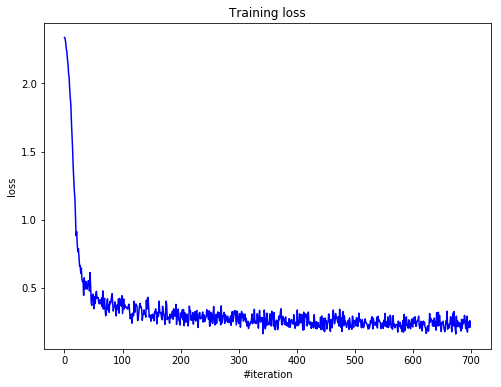

Current loss: 0.212435
Time passed: 223.528693 seconds


In [79]:
net = Sequential()
net.add(Linear(784, 10))
net.add(SoftPlus())
net.add(Linear(10, 10))
net.add(LogSoftMax())
print(net)
SoftPlus_hist = nettest(1e-1, 0.9,5,500);

#### `SoftPlus` activation function WITH  `BatchNormalization`

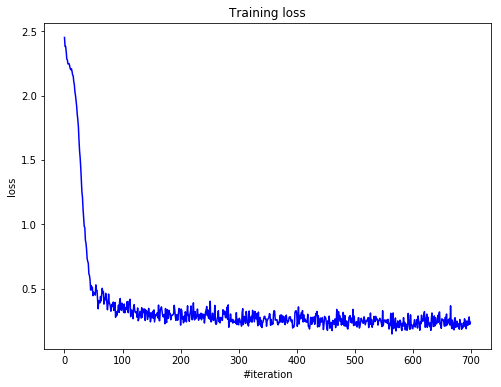

Current loss: 0.237609
Time passed: 230.007135 seconds


In [80]:
net = Sequential()
net.add(Linear(784, 10))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(10))
net.add(SoftPlus())
net.add(Linear(10, 10))
net.add(LogSoftMax())
print(net)
Batch_SoftPlus_hist = nettest(1e-1, 0.9,5,500);

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


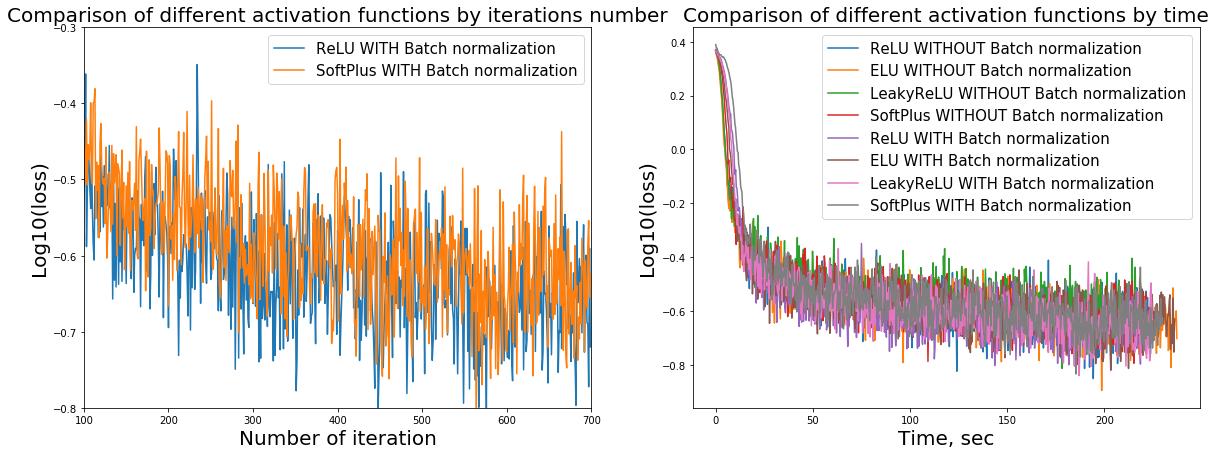

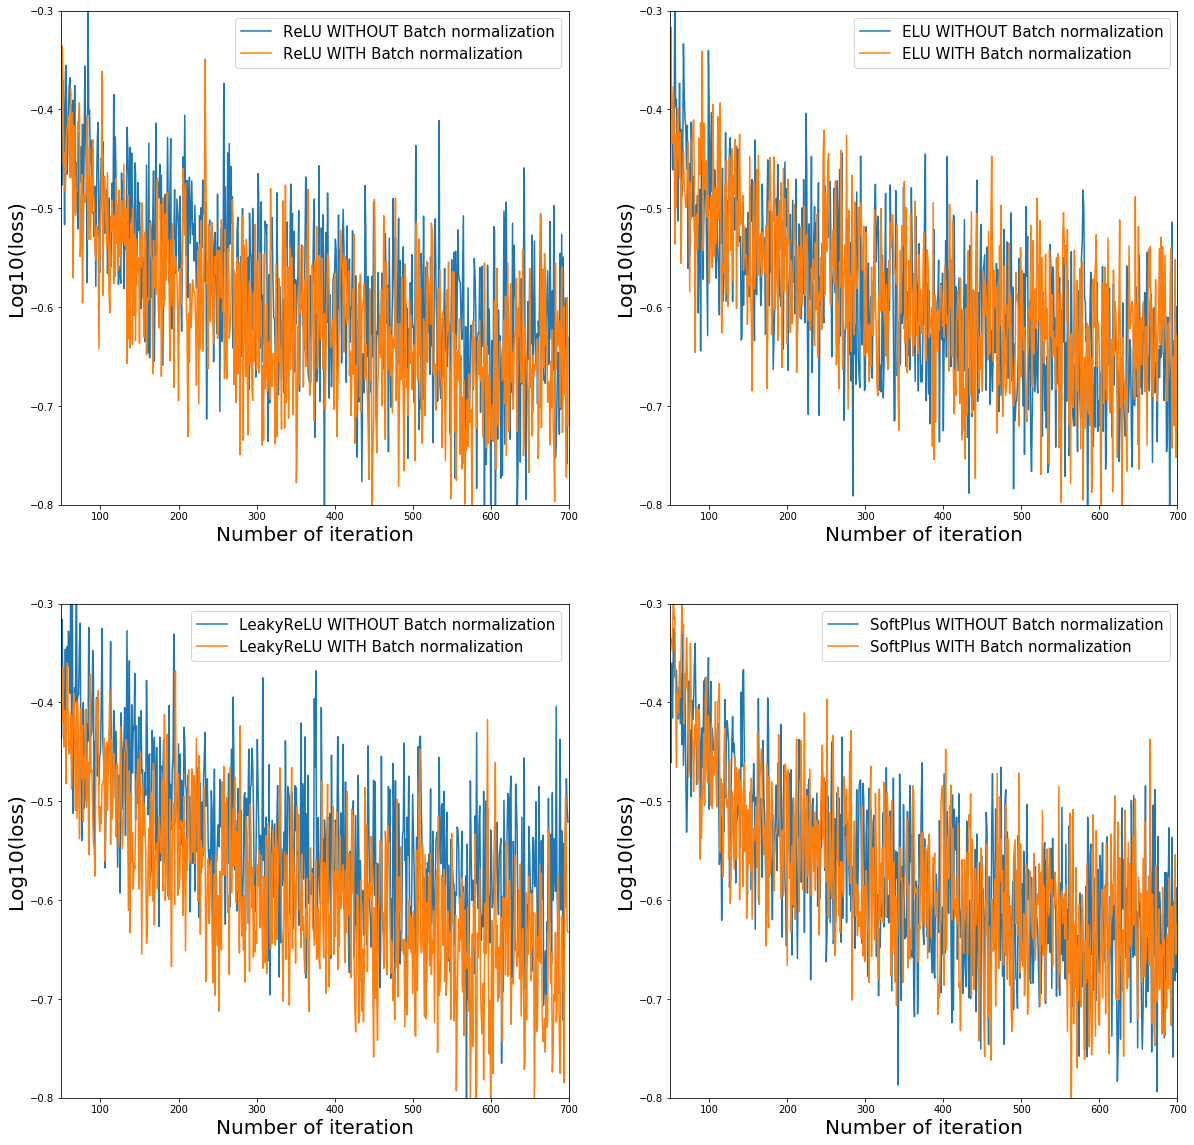

In [610]:
fig, (im1,im2) = plt.subplots(1, 2, figsize=(20, 7))
im1.set_title("Comparison of different activation functions by iterations number",fontsize=20)
im1.set_xlabel("Number of iteration",fontsize=20)
im1.set_ylabel("Log10(loss)",fontsize=20)
#im1.plot(np.log10(ReLU_hist), label = 'ReLU WITHOUT Batch normalization')
#im1.plot(np.log10(ELU_hist), label = 'ELU WITHOUT Batch normalization')
#im1.plot(np.log10(LeakyReLU_hist), label = 'LeakyReLU WITHOUT Batch normalization')
#im1.plot(np.log10(SoftPlus_hist), label = 'SoftPlus WITHOUT Batch normalization')
im1.plot(np.log10(Batch_ReLU_hist), label = 'ReLU WITH Batch normalization')
#im1.plot(np.log10(Batch_ELU_hist), label = 'ELU WITH Batch normalization')
#im1.plot(np.log10(Batch_LeakyReLU_hist), label = 'LeakyReLU WITH Batch normalization')
im1.plot(np.log10(Batch_SoftPlus_hist), label = 'SoftPlus WITH Batch normalization')
im1.legend(fontsize=15)
im1.set_xlim(100,700);
im1.set_ylim(-0.8,-0.3);
im2.set_title("Comparison of different activation functions by time",fontsize=20)
im2.set_xlabel("Time, sec",fontsize=20)
im2.set_ylabel("Log10(loss)",fontsize=20)
im2.plot(np.array(range(len(ReLU_hist)))/len(ReLU_hist)*224.402845,np.log10(ReLU_hist), label = 'ReLU WITHOUT Batch normalization')
im2.plot(np.array(range(len(ELU_hist)))/len(ELU_hist)*237.629034,np.log10(ELU_hist), label = 'ELU WITHOUT Batch normalization')
im2.plot(np.array(range(len(LeakyReLU_hist)))/len(LeakyReLU_hist)*219.291758,np.log10(LeakyReLU_hist), label = 'LeakyReLU WITHOUT Batch normalization')
im2.plot(np.array(range(len(SoftPlus_hist)))/len(SoftPlus_hist)*223.528693,np.log10(SoftPlus_hist), label = 'SoftPlus WITHOUT Batch normalization')
im2.plot(np.array(range(len(Batch_ReLU_hist)))/len(Batch_ReLU_hist)*224.320653,np.log10(Batch_ReLU_hist), label = 'ReLU WITH Batch normalization')
im2.plot(np.array(range(len(Batch_ELU_hist)))/len(Batch_ELU_hist)*236.382500,np.log10(Batch_ELU_hist), label = 'ELU WITH Batch normalization')
im2.plot(np.array(range(len(Batch_LeakyReLU_hist)))/len(Batch_LeakyReLU_hist)*225.222701,np.log10(Batch_LeakyReLU_hist), label = 'LeakyReLU WITH Batch normalization')
im2.plot(np.array(range(len(Batch_SoftPlus_hist)))/len(Batch_SoftPlus_hist)*230.007135,np.log10(Batch_SoftPlus_hist), label = 'SoftPlus WITH Batch normalization')
#plt.ylim(-0.6,0.4);
im2.legend(fontsize=15)
fig.show()

fig, ((im1,im2),(im3,im4)) = plt.subplots(2, 2, figsize=(20, 20))
#im1.set_title("Comparison of different activation functions with and without BatchNorm",fontsize=30)
im1.plot(np.log10(ReLU_hist), label = 'ReLU WITHOUT Batch normalization')
im1.plot(np.log10(Batch_ReLU_hist), label = 'ReLU WITH Batch normalization')
im1.set_xlabel("Number of iteration",fontsize=20)
im1.set_ylabel("Log10(loss)",fontsize=20)
im1.legend(fontsize=15)
im1.set_xlim(50,700);
im1.set_ylim(-0.8,-0.3);
#im2.title("Comparison of different activation functions with and without BatchNorm",fontsize=30)
im2.set_xlabel("Number of iteration",fontsize=20)
im2.set_ylabel("Log10(loss)",fontsize=20)
im2.plot(np.log10(ELU_hist), label = 'ELU WITHOUT Batch normalization')
im2.plot(np.log10(Batch_ELU_hist), label = 'ELU WITH Batch normalization')
im2.legend(fontsize=15)
im2.set_xlim(50,700);
im2.set_ylim(-0.8,-0.3);
#im3.title("Comparison of different activation functions with and without BatchNorm",fontsize=30)
im3.set_xlabel("Number of iteration",fontsize=20)
im3.set_ylabel("Log10(loss)",fontsize=20)
im3.plot(np.log10(LeakyReLU_hist), label = 'LeakyReLU WITHOUT Batch normalization')
im3.plot(np.log10(Batch_LeakyReLU_hist), label = 'LeakyReLU WITH Batch normalization')
im3.legend(fontsize=15)
im3.set_xlim(50,700);
im3.set_ylim(-0.8,-0.3);
#im4.title("Comparison of different activation functions with and without BatchNorm",fontsize=30)
im4.set_xlabel("Number of iteration",fontsize=20)
im4.set_ylabel("Log10(loss)",fontsize=20)
im4.plot(np.log10(SoftPlus_hist), label = 'SoftPlus WITHOUT Batch normalization')
im4.plot(np.log10(Batch_SoftPlus_hist), label = 'SoftPlus WITH Batch normalization')
im4.legend(fontsize=15)
im4.set_xlim(50,700);
im4.set_ylim(-0.8,-0.3);
fig.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

# Your answer goes here. "################################################"

The computational times lie in one order of magnitude, so there is nearly no difference in computing time. The plots show that at the beginning of the training (first 20 iterations) all activation functions behave better without BatchNormalization in terms of descent speed. But that is trully a negligible difference because 20 iterations is significantly less one batch size. On the large scale, comparing activation functions with BatchNormalization and without it, BatchNormalization slightly acccelerates convergence speed. The improvement of BatchNorm is really noticeable for ReLU and LeakyReLU. For the rest BatchNorm is almost invisible. 

In terms of large scale, WITHOUT BatchNormalization there is almost no difference between ReLU, ELU and SoftPlus. But LeakyReLU converges noticeably slower than ReLU, ELU and SoftPlus.

In terms of large scale, WITH BatchNormalization ReLU converges slightly faster than ELU, LeakyReLU and SoftPlus.

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [195]:
# Your code goes here. ################################################
X_train = X[:60000,:];
Y_train = Y[:60000,:];
X_test = X[60000:,:];
Y_test = Y[60000:,:];

net = Sequential()
net.train()
net.add(Dropout(0.2))
net.add(Linear(784, 300))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(300))
net.add(Dropout())
net.add(ReLU())
net.add(Linear(300, 100))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(100))
net.add(Dropout())
net.add(ReLU())
net.add(Linear(100, 10))
net.add(LogSoftMax())
print(net)

def nettrain(net, X,Y, lr, mom, n_epoch,batch_size):
    loss_history = []
    net.train()
    # Optimizer params
    optimizer_config = {'learning_rate' : lr, 'momentum': mom}
    optimizer_state = {}
    criterion = ClassNLLCriterion();
    start_time = time.time()
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)
        print("Time passed: %f seconds" % (time.time() - start_time))
    return loss_history;

Dropout
Linear 784 -> 300
BatchNormalization
ChannelwiseScaling
Dropout
ELU
Linear 300 -> 100
BatchNormalization
ChannelwiseScaling
Dropout
ELU
Linear 100 -> 10
LogSoftMax



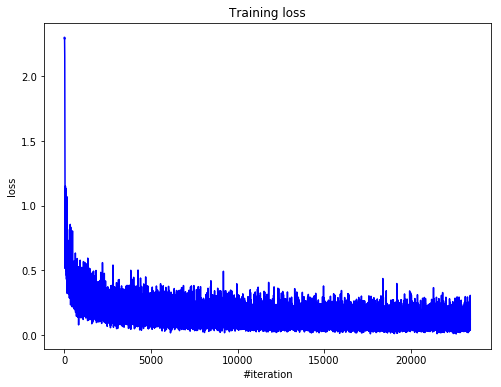

Current loss: 0.122911
Time passed: 2559.453321 seconds


In [196]:
h_train = nettrain(net,X_train,Y_train,0.1,0.97,50,128);

In [248]:
N_neg = 0;
net.evaluate();
for i in range(np.shape(Y_test)[0]):
    if np.argmin(np.abs(net.forward(X_test[i]))) != int(np.argmax(Y_test[i,:])):
        N_neg +=1;
print("TEST ERROR RATE: %.2f%%" % (N_neg/np.shape(Y_test)[0]*100));

TEST ERROR RATE: 3.45%
ACCURACY: 96.55%


Print here your accuracy. It should be around 90%.

In [249]:
# Your answer goes here. ################################################
print("ACCURACY: %.2f%%" % (100-N_neg/np.shape(Y_test)[0]*100));

ACCURACY: 96.55%


# Autoencoder

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use `MSECriterion` to score the reconstruction. Use `BatchNormalization` (followed by `ChannelwiseScaling` as usual) between `Linear` and `ReLU`. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [531]:
# Your code goes here. ################################################
net = Sequential()
net.train()
net.add(Linear(784, 512))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(512))
net.add(ReLU())
net.add(Linear(512, 256))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(256))
net.add(ReLU())
net.add(Linear(256, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())
net.add(Linear(128, 30))
#net.add(BatchNormalization())
#net.add(ChannelwiseScaling(30))
net.add(Linear(30, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())
net.add(Linear(128, 256))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(256))
net.add(ReLU())
net.add(Linear(256, 512))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(512))
net.add(ReLU())
net.add(Linear(512, 784))
print(net)

def compresstrain(net, X,Y, lr, mom, n_epoch,batch_size):
    net.train()
    loss_history = []
    # Optimizer params
    lr *=2;
    optimizer_config = {'learning_rate' : lr, 'momentum': mom}
    optimizer_state = {}
    criterion = MSECriterion();
    #criterion = ClassNLLCriterion();
    start_time = time.time()
    for i in range(n_epoch):
        if (i%3) == 0:
            lr /= 2;
            optimizer_config = {'learning_rate' : lr, 'momentum': mom};
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, x_batch)

            # Backward
            dp = criterion.backward(predictions, x_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)
            
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)
        print("Time passed: %f seconds" % (time.time() - start_time))
    return loss_history;

Linear 784 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Linear 512 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Linear 256 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 30
Linear 30 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Linear 256 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Linear 512 -> 784



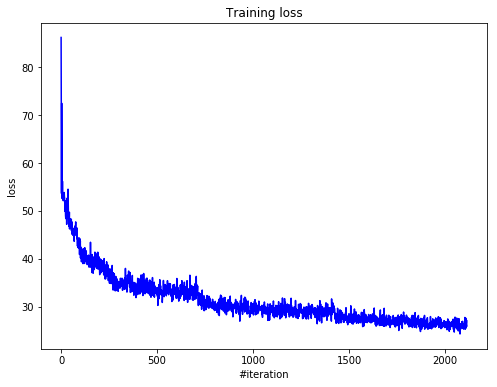

Current loss: 25.930587
Time passed: 401.334629 seconds


In [532]:
compress_hist = compresstrain(net,X_train,Y_train,0.1,0.9,9,256);

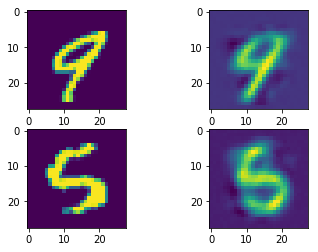

In [533]:
net.evaluate();
i = 55100;
j = 35100;
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.imshow(np.reshape(X[i,:],(28,28)));

ax2 = fig.add_subplot(222)
ax2.imshow(np.reshape(net.forward(X[i,:]),(28,28)))

ax1 = fig.add_subplot(223)
ax1.imshow(np.reshape(X[j,:],(28,28)));

ax2 = fig.add_subplot(224)
ax2.imshow(np.reshape(net.forward(X[j,:]),(28,28)))

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [535]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################
net.evaluate();
inner_train = net.modules[0].forward(X_train);
inner_test = net.modules[0].forward(X_test);
for i in range(1,13):
    inner_train = net.modules[i].forward(inner_train);
    inner_test = net.modules[i].forward(inner_test);

In [536]:
# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 10))
cnet.add(LogSoftMax())

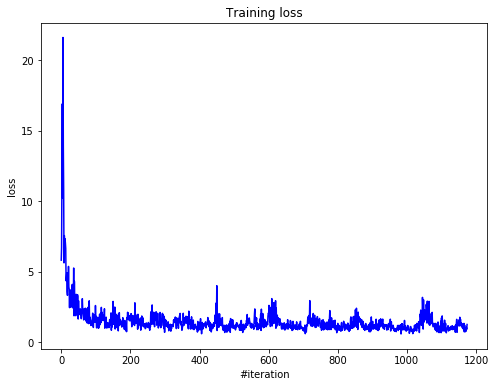

Current loss: 1.252958
Time passed: 190.332476 seconds


In [537]:
# Learn the weights
# Your code goes here. ################################################
cnet_hist = nettrain(cnet,inner_train,Y_train,0.1,0.9,5,256);

In [545]:
# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################
import copy
autoenc = copy.deepcopy(net);
for i in range(13):
    del autoenc.modules[-1];

In [546]:
# And add learned layers ontop.
autoenc.add(cnet[0])
autoenc.add(cnet[1])

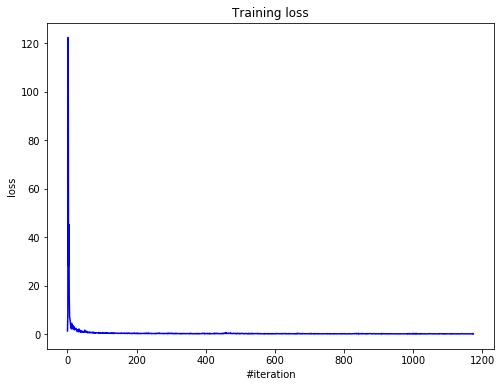

Current loss: 0.041499
Time passed: 294.255479 seconds


In [549]:
# Now optimize whole model
# Your code goes here. ################################################
autoenc.train()
autoenc_hist = nettrain(autoenc,X_train,Y_train,0.1,0.9,5,256);

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

In [550]:
autoenc.evaluate();
for i in range(np.shape(Y_test)[0]):
    if np.argmin(np.abs(autoenc.forward(X_test[i]))) != int(np.argmax(Y_test[i,:])):
        N_neg +=1;
print("TEST ERROR RATE: %.2f%%" % (N_neg/np.shape(Y_test)[0]*100));

TEST ERROR RATE: 9.08%


I don't think that now it makes sense to build real-world classifiers such way. The produced classifier has larger error rate on a test set than classifier realized above (9.08% comparing to 3.45%), so it does not work better. The overall training time on my laptop is smaller: about 885 seconds for that classifier and 2559 seconds for classifier reasized above. So the timings are of the same order. 8 years ago (my laptop is 7 years old) there were no powerfull GPUs, but definetely were personal computers with larger computational power than my laptop, so I guess that with enough knowledge, doing the same was absolutely possible. I think, that the main things that dramaticaly increased besides computational power, are the humanity theoretical and practical knowledge on Deep Learning networks, a quality of datasets and a convinience of programming languages and IDEs.

Run PCA with 30 components on the train set, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from validation set. Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [551]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################
from sklearn.decomposition import PCA
pca = PCA(n_components=30);
pcacomp = pca.fit_transform(X_test);
pcacomp = pca.inverse_transform(pcacomp);

In [567]:
def show_images(im1,im2,im3):
    fig, (im_1, im_2,im_3) = plt.subplots(1, 3, figsize=(5, 20))
    im_1.imshow(im1, cmap='gray')
    im_1.set_title('Original')
    im_1.set_axis_off()
    im_2.imshow(im2, cmap='gray')
    im_2.set_title('PCA compressed')
    im_2.set_axis_off()
    im_3.imshow(im3, cmap='gray')
    im_3.set_title('Deep Autoencoder')
    im_3.set_axis_off()
    fig.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


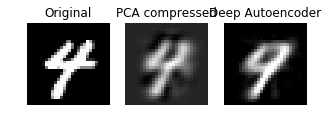

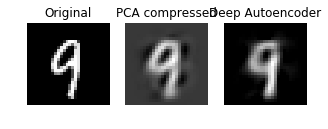

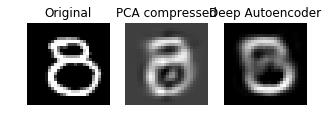

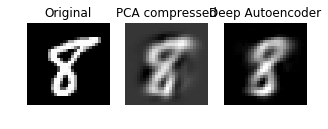

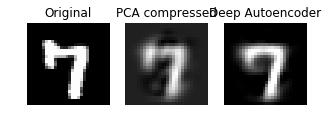

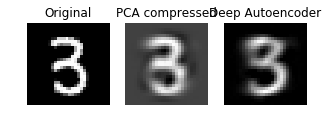

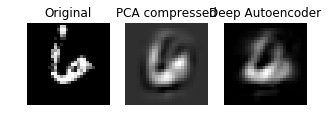

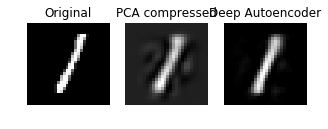

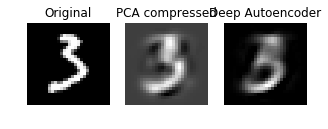

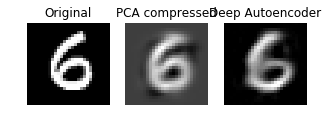

In [568]:
net.evaluate();
k = 1;
for i in np.random.randint(0,10000,10):
    show_images(np.reshape(X_test[i,:],(28,28)),np.reshape(pcacomp[i,:],(28,28)),np.reshape(np.clip(net.forward(X_test[i,:]),0,1),(28,28)));